# Load basic config

In [9]:
import qubecalib as qc
import qubecalib.ui as ui
from qubecalib import UpConverter, LocalOscillator
from qubecalib.ui import Qube
import e7awgsw

QUBE = Qube()
display(ui.LoadConfigPanel(QUBE))
# ハードウェアのコンフィグが終わっていれば，Load した時点で Qube オブジェクトから QuBE を操れる

LoadConfigPanel(children=(Text(value='qube_riken_1-01.yml', description='Config'), Button(description='Load', …

In [10]:
QUBE.config

{'bitfile': '0d60b1.bit',
 'ipfpga': '10.1.0.22',
 'iplsi': '10.5.0.22',
 'macfpga': '00-0A-35-0D-60-B1',
 'maclsi': '00-1B-1A-EE-01-21',
 'type': 'A'}

# Initialize LSIs

In [2]:
QUBE.do_init(message_out=True)

init LMX2594 for ctrl/readout
init LMX2594 for AD9082
init ADRF6780
init AD5328
init GPIOs for RF-switches
init AD9082
Hello World 

0x4=82
adi_ad9081_device_reset(...)
adi_ad9081_device_init(...)
api v1.0.6 commit 6eb6c66 for ad9081 
host is using little endian mode.
adi_ad9081_device_spi_config(...)
adi_ad9081_device_reg8_access_check(...)
adi_ad9081_device_power_status_check(...)
adi_ad9081_device_clk_config_set(...)
adi_ad9081_device_boot_pre_clock(...)
adi_ad9081_device_chip_id_get(...)
device is ad9082 r3
adi_ad9081_device_laminate_id_get(...)
adi_ad9081_device_die_id_get(...)
adi_ad9081_dac_digital_logic_enable_set(...)
adi_ad9081_dac_spi_enable_set(...)
adi_ad9081_device_aclk_receiver_enable_set(...)
adi_ad9081_device_clk_pll_enable_set(...)
adi_ad9081_adc_clk_div_set(...)
adi_ad9081_device_clk_up_div_set(...)
adi_ad9081_device_boot_post_clock(...)
adi_ad9081_adc_core_analog_regs_enable_set(...)
adi_ad9081_adc_core_analog_regs_enable_set(...)
adi_ad9081_dac_spi_enable_set(...)


# Restart ADC/DAC

In [9]:
QUBE.restart_ad9082(message_out=False)

## Check ADC/DAC status

In [11]:
print(QUBE.qube.ad9082[0].get_jesd_status())
print(QUBE.qube.ad9082[1].get_jesd_status())
print(QUBE.config['iplsi'])
print(QUBE.config['ipfpga'])
print(QUBE.config['bitfile'])

[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
10.5.0.22
10.1.0.22
0d60b1.bit


# Support Functions

In [12]:
import numpy as np

def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.local.lsi, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.local.lsi)

def set_nco(port, mhz):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)


def sendrecv(wave_params, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*AWG_LIST)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, wave_params)
        # キャプチャパラメータの設定
        sr.set_capture_params(
            cap_ctrl,
            awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
            awg_to_wave_sequence[AWG_LIST.readout_awg_0],
            capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*AWG_LIST)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
    return capture_unit_to_capture_data

def sendrecv2(wave_params, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*AWG_LIST)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, wave_params)
        # キャプチャパラメータの設定
        sr.set_capture_params(
            cap_ctrl,
            awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
            awg_to_wave_sequence[AWG_LIST.readout_awg_0],
            capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*AWG_LIST)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)
        # キャプチャデータ取得
        print('cap',)
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        print(list(capture_unit_to_capture_data))
        print('awg',)
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
        print(list(awg_to_wave_data))
        print('done')
    return capture_unit_to_capture_data, awg_to_wave_data


def myplot(axs, data):
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in data.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    for i, v in enumerate(o[::4]):
        axs[i,0].plot(time, v[:,0])
        axs[i,1].plot(time, v[:,1])
        
def set_vatt(vatt, v, apply=True): # max 4095
    vatt.lsi.write_value(vatt.ch, v)
    if apply:
        apply_vatt(vatt.lsi)

def apply_vatt(ad5328):
    ad5328.write_value(0xA, 0x002)
    return True


# CW Power Check

- Ctrl -> Port 5 -20 dBm  Q14:8.233GHz(10900,2700), Q15:7.741GHz -19.6dBm 0x400
- Readout -> Port 0  -40 ~ -50 dBm @ Q14:9.611GHz(8200,1400), Q15:9.477GHz -45.93dBm 0x500
- Readin -> Port 1

スペアナの入力に 10dB 入っているので注意

In [5]:
_ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]

0 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
1 RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz 
5 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
6 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
7 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
8 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
12 RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz 
13 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive


In [ ]:
qc.LongSend.start(p = QUBE.qube.ports[5],atts=[0]*3) # dBatt

In [31]:
qc.LongSend.stop(QUBE.qube.ports[0])

In [25]:
p = QUBE.qube.ports[5]
p.set_lo(10500)
p.set_if(2700)
p.get_status()

'RF = 7800.000 MHz LO = 10500    MHz IF = 2700.000 MHz LSB/USB: LSB MODE AWG: Inactive'

In [11]:
set_vatt(p.upconv.vatt, 0xA00)

In [30]:
### 出力校正
# スペアナ入力部の 10dB ATT も含む
# VATT, P5 @ RF:7800 + 2.5, LO:10500, IF:2700
'''
0xC00, 0.75
0xB00, -0.1
0xA00, -2.32
0x900, -5.51
0x800, -8.57
0x700, -11.53
0x600, -14.36
0x500, -17.12
0x400, -19.62
0x300, -21.19
0x200, -21.45
0x100, -21.44
0x000, -21.51
'''

'\n0xC00, 0.75\n0xB00, -0.1\n0xA00, -2.32\n0x900, -5.51\n0x800, -8.57\n0x700, -11.53\n0x600, -14.36\n0x500, -17.12\n0x400, -19.62\n0x300, -21.19\n0x200, -21.45\n0x100, -21.44\n0x000, -21.51\n'

In [36]:
p = QUBE.qube.ports[0]
p.set_lo(8200)
p.set_if(1400)
p.get_status()

'RF = 9600.000 MHz LO =  8200    MHz IF = 1400.000 MHz LSB/USB: USB MODE AWG: Inactive'

In [28]:
set_vatt(p.upconv.vatt, 0x700) # -49.63 dBm + 10dB @ 9600, 8200, 1400

In [23]:
### 出力校正
# スペアナ入力部の 10dB ATT も含む
# VATT, P0 @ RF:9600 + 2.5, LO:8200, IF:1400
'''
0x900, -33.23
0x800, -36.77
0x700, -39.89
0x600, -42.62
0x500, -45.93
'''
#VATT, P0 @ RF:9500 + 2.5, LO:8100, IF:1400
'''
0xC00, -38.93
0xB00, -40.50
0xA00, -43.28
0x900, -46.83
0x800, -49.72
0x700, -52.13
'''

'\n0xC00, -38.93\n0xB00, -40.50\n0xA00, -43.28\n0x900, -46.83\n0x800, -49.72\n0x700, -52.13\n'

0x700# パルスシーケンスのテスト

LSIs## send_recv_dsp/send_recv_integ.py

In [47]:
611//15.625

39.0

In [48]:
15.625 * 38

593.75

# 共振器の読み出しテスト

9601.0


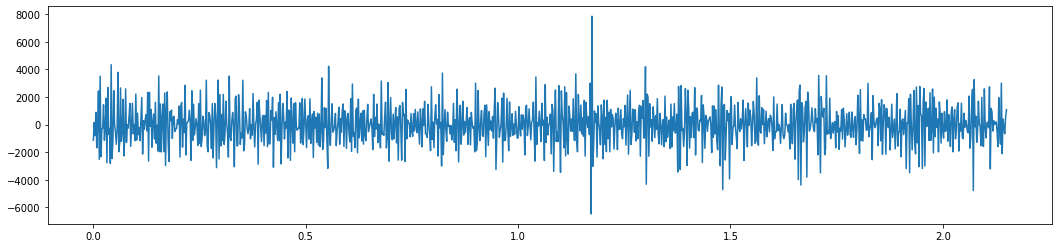

9602.0


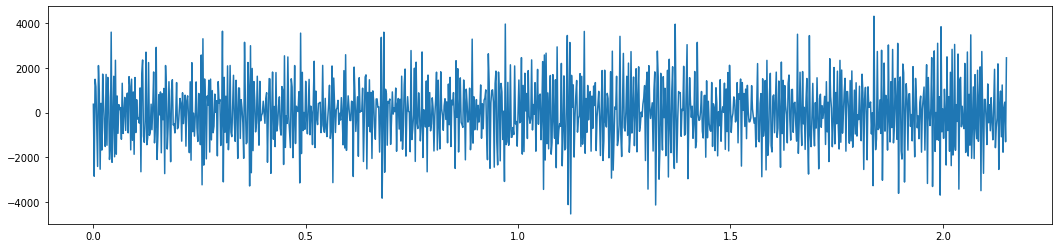

9603.0


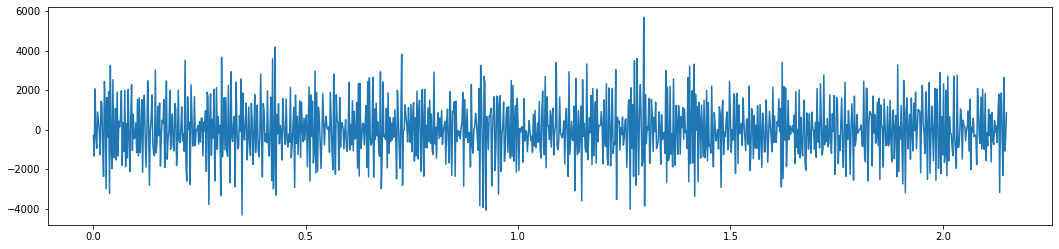

9604.0


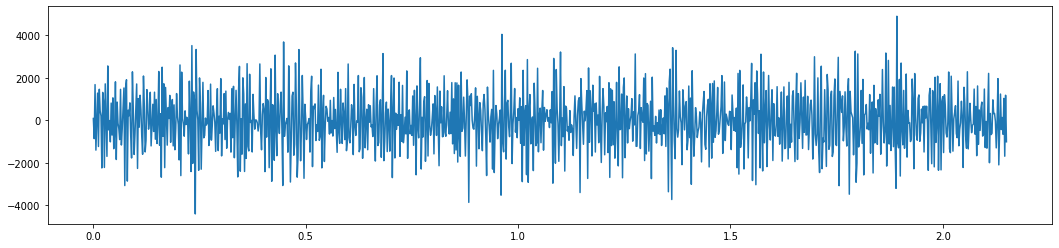

9605.0


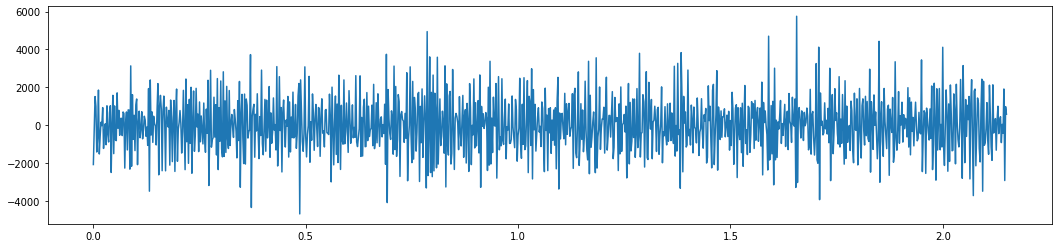

9606.0


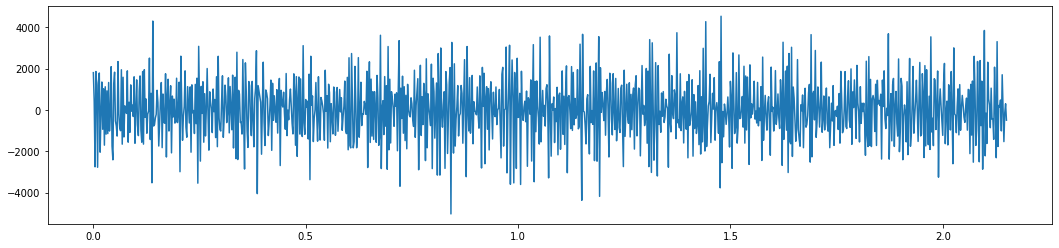

9607.0


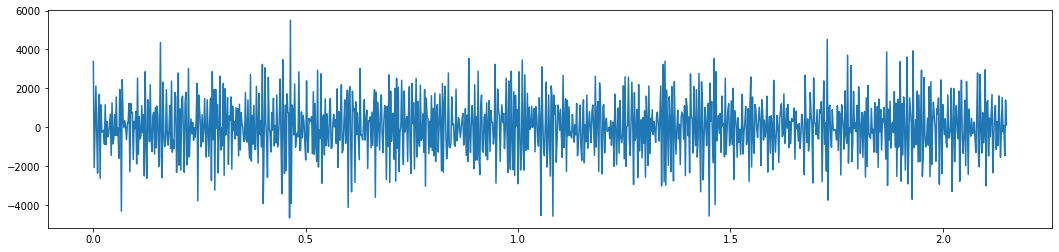

9608.0


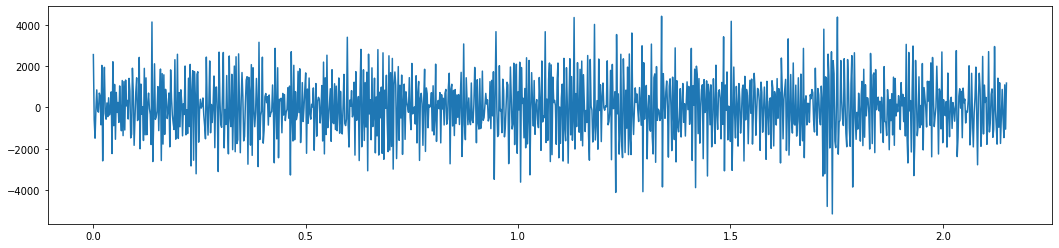

9609.0


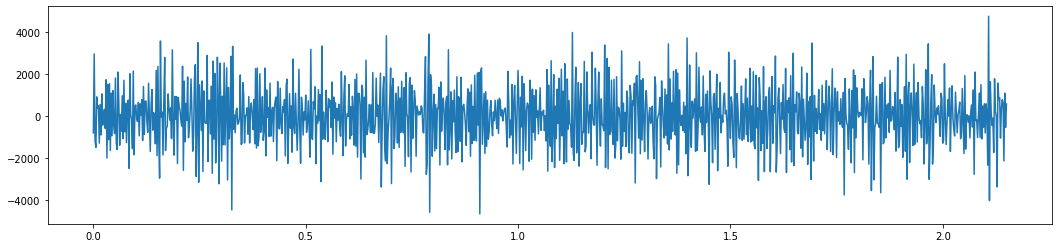

9610.0


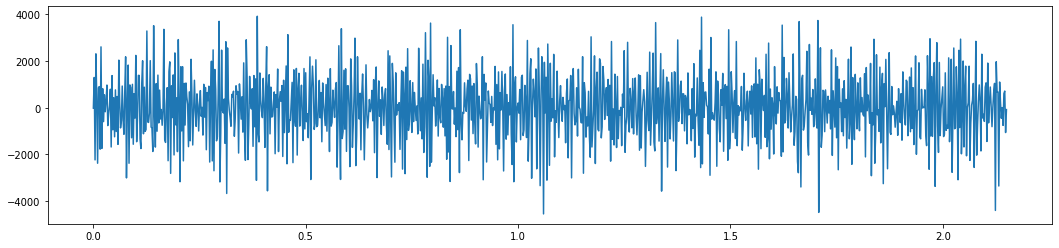

9611.0


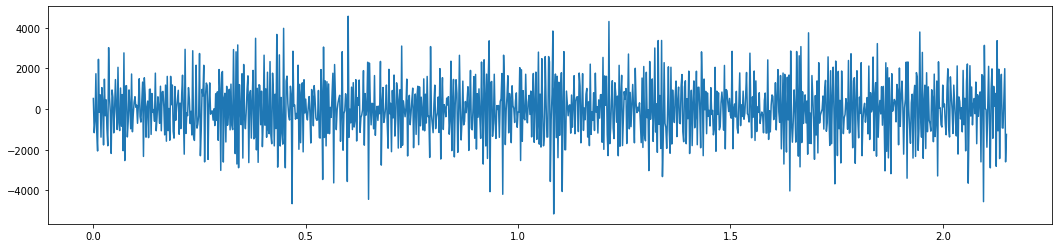

9612.0


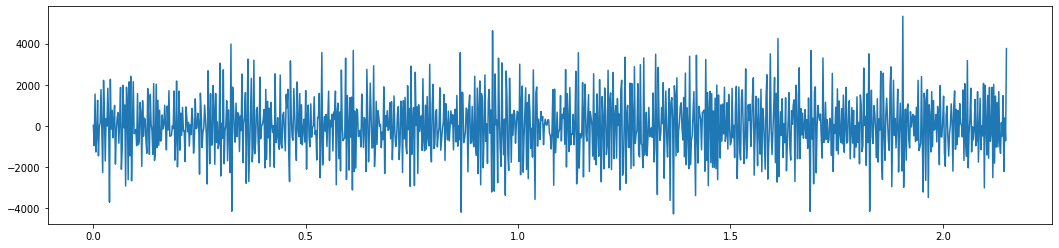

9613.0


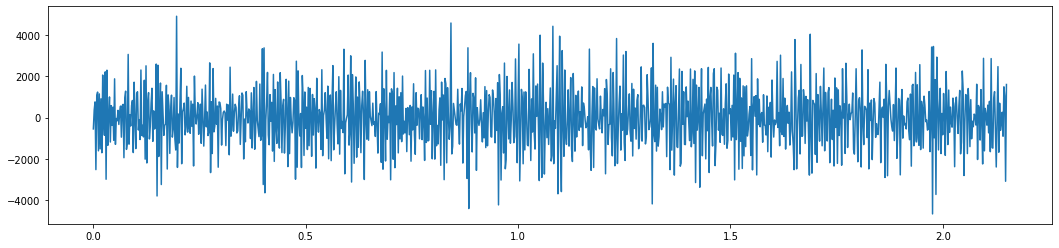

9614.0


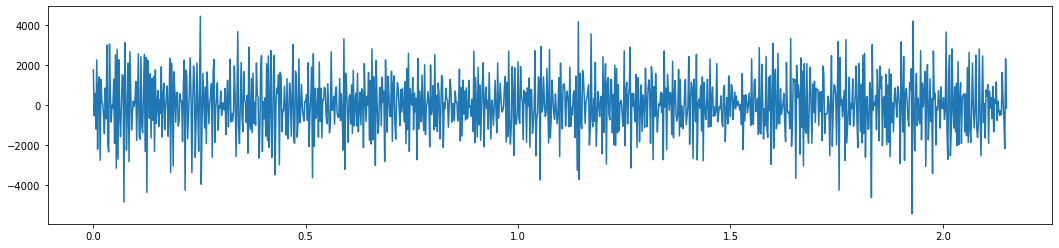

9615.0


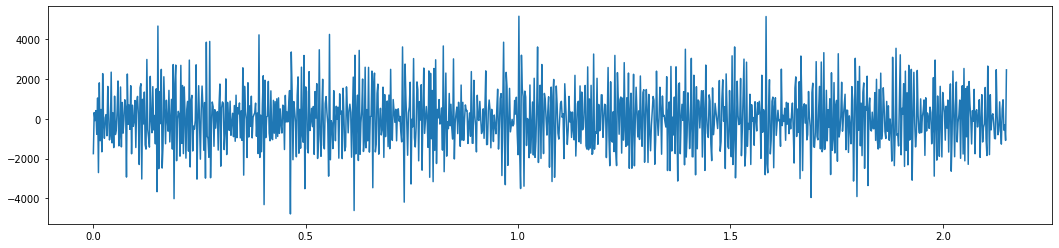

9616.0


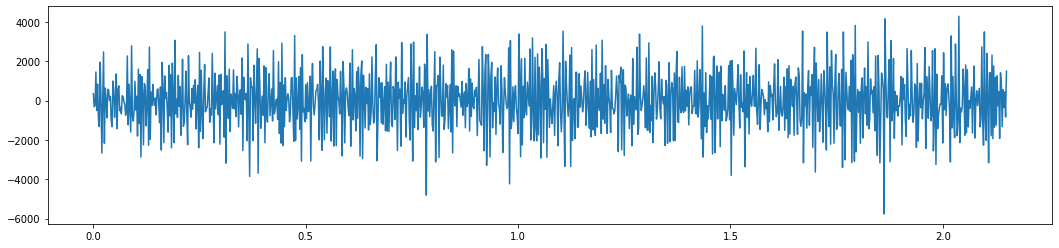

9617.0


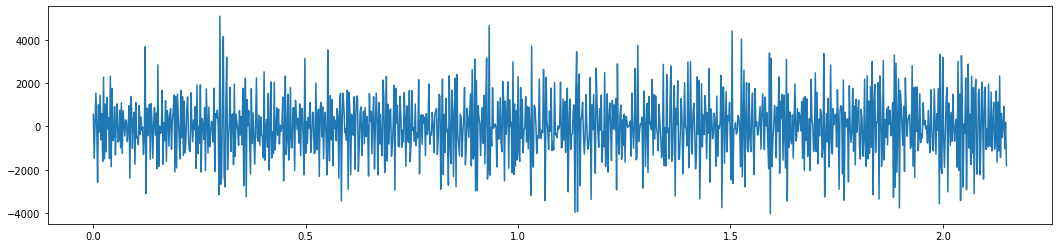

9618.0


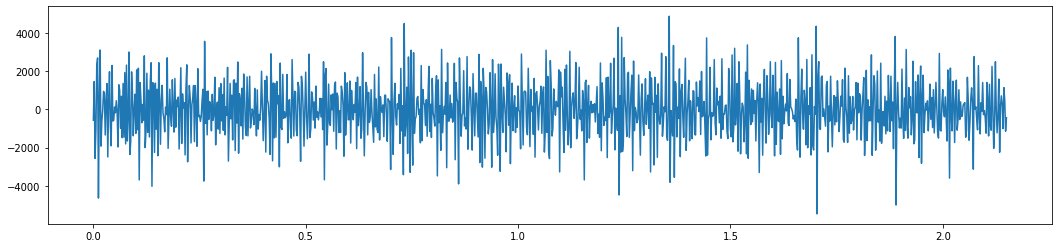

9619.0


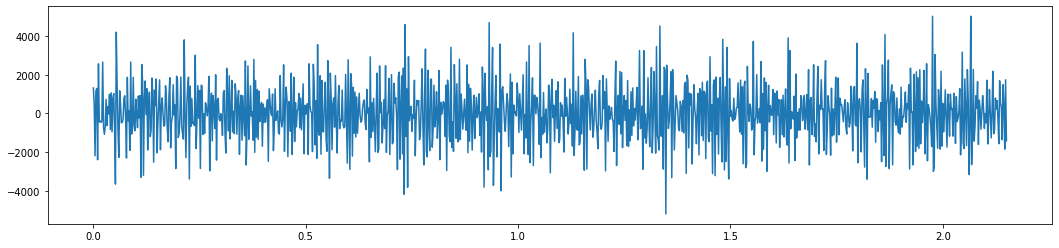

9620.0


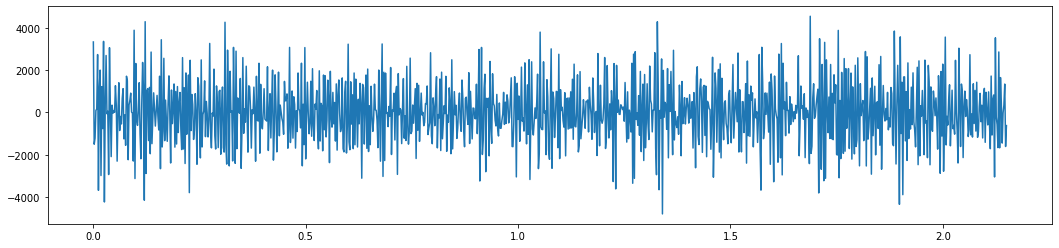

9621.0


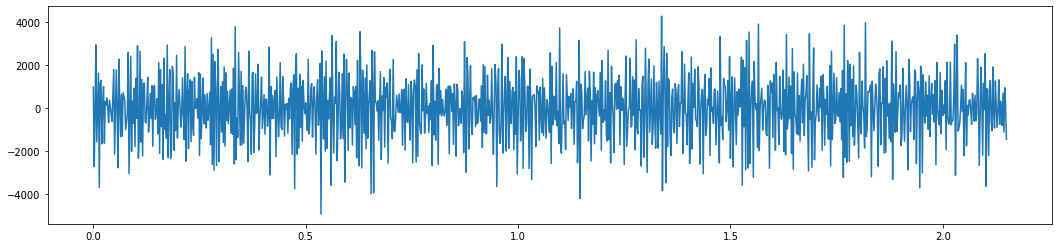

In [13]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
from collections import namedtuple
import pickle
import numpy as np

qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'

p = QUBE.qube.ports[5]
p.set_lo(10900)
p.set_if(2700)
p.get_status()
set_vatt(p.upconv.vatt, 0x400)

sr.ADDITIONAL_CAPTURE_DELAY = 0

TARGET = 9611
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF

p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF)
p.get_status()
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
set_vatt(p.upconv.vatt, 0x600) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)


#IF = TARGET - LO - FAWG0

#FAWG0 = 9711 - LO - IF


#Fawg = 151 # MHz

rslt = []
iq_mean = []
for Fawg in [FAWG0,] + 10*np.linspace(-1,1,21):
# 0.1374435494319231for Fawg in 111 + np.ones(11):
    print(LO + IF + Fawg)
    wparams = sr.wave_params(
        num_wait_words = 0,
        ctrl_freq = 100, # MHz
        ctrl_wave_len = ctrl_wave_len, # ns
        readout_freq = Fawg, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        # num_chunk_repeats = 10000, # 積算回数
        num_chunk_repeats = 1# 積算回数
    )
    
    # _ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]
    
    family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
    fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
    #[set_nco_ifadc(port[0], 1400, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
    QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    d = sendrecv(wparams, capture_modules, False, server_ip_addr)
    rslt.append(d)
    
    %matplotlib inline
    import numpy as np
    import matplotlib.pylab as plt

    f, axs = plt.subplots(1,1, figsize=(18,4))
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    local = np.exp(-1j*(2*np.pi*Fawg*time))
    i, v = 0, o[4]
    w = v[:,0] + 1j * v[:,1]
    x = w# * local
    #iq_mean.append(np.mean(x))
    #axs[i,0].plot(time, np.abs(x))#np.real(x))
    axs.plot(time, np.real(x))
    # axs[i,1].plot(time, np.unwrap(np.angle(x)))
    #axs[i,0].set_ylim(0,2e+5)
    plt.show()

# AWGの波形も同時に記録

In [ ]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
from collections import namedtuple
import pickle

qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'

p = QUBE.qube.ports[5]
p.set_lo(10900)
p.set_if(2700)
p.get_status()
set_vatt(p.upconv.vatt, 0x400)

sr.ADDITIONAL_CAPTURE_DELAY = 0

TARGET = 9611
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF

p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF)
p.get_status()
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
set_vatt(p.upconv.vatt, 0x600) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)


#IF = TARGET - LO - FAWG0

#FAWG0 = 9711 - LO - IF


#Fawg = 151 # MHz

rslt = []
iq_mean = []
for Fawg in FAWG0 + 10*np.linspace(-1,1,21):
# 0.1374435494319231for Fawg in 111 + np.ones(11):
    print(LO + IF + Fawg,)
    wparams = sr.wave_params(
        num_wait_words = 0,
        ctrl_freq = 100, # MHz
        ctrl_wave_len = ctrl_wave_len, # ns
        readout_freq = Fawg, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        # num_chunk_repeats = 10000, # 積算回数
        num_chunk_repeats = 10000# 積算回数
    )
    
    # _ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]
    
    family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
    fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
    #[set_nco_ifadc(port[0], 1400, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
    QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    d, d2 = sendrecv2(wparams, capture_modules, False, server_ip_addr)
    rslt.append({'cap': d, 'awg': d2})
    
#     %matplotlib inline
#     import numpy as np
#     import matplotlib.pylab as plt

#     f, axs = plt.subplots(1,1, figsize=(18,4))
#     SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
#     o = [np.array(v) for k, v in d.items()]
#     time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
#     local = np.exp(-1j*(2*np.pi*Fawg*time))
#     i, v = 0, o[4]
#     w = v[:,0] + 1j * v[:,1]
#     x = w# * local
#     #iq_mean.append(np.mean(x))
#     #axs[i,0].plot(time, np.abs(x))#np.real(x))
#     axs.plot(time, np.real(x))
#     # axs[i,1].plot(time, np.unwrap(np.angle(x)))
#     #axs[i,0].set_ylim(0,2e+5)
#     plt.show()

9601.0
cap
[<CaptureUnit.U0: 0>, <CaptureUnit.U1: 1>, <CaptureUnit.U2: 2>, <CaptureUnit.U3: 3>, <CaptureUnit.U4: 4>, <CaptureUnit.U5: 5>, <CaptureUnit.U6: 6>, <CaptureUnit.U7: 7>]
awg
[<AWG.U0: 0>, <AWG.U13: 13>, <AWG.U2: 2>, <AWG.U15: 15>]
done
9602.0
cap
[<CaptureUnit.U0: 0>, <CaptureUnit.U1: 1>, <CaptureUnit.U2: 2>, <CaptureUnit.U3: 3>, <CaptureUnit.U4: 4>, <CaptureUnit.U5: 5>, <CaptureUnit.U6: 6>, <CaptureUnit.U7: 7>]
awg
[<AWG.U0: 0>, <AWG.U13: 13>, <AWG.U2: 2>, <AWG.U15: 15>]
done
9603.0
cap
[<CaptureUnit.U0: 0>, <CaptureUnit.U1: 1>, <CaptureUnit.U2: 2>, <CaptureUnit.U3: 3>, <CaptureUnit.U4: 4>, <CaptureUnit.U5: 5>, <CaptureUnit.U6: 6>, <CaptureUnit.U7: 7>]
awg
[<AWG.U0: 0>, <AWG.U13: 13>, <AWG.U2: 2>, <AWG.U15: 15>]
done
9604.0
cap
[<CaptureUnit.U0: 0>, <CaptureUnit.U1: 1>, <CaptureUnit.U2: 2>, <CaptureUnit.U3: 3>, <CaptureUnit.U4: 4>, <CaptureUnit.U5: 5>, <CaptureUnit.U6: 6>, <CaptureUnit.U7: 7>]
awg
[<AWG.U0: 0>, <AWG.U13: 13>, <AWG.U2: 2>, <AWG.U15: 15>]
done
9605.0
cap


In [1]:
rslt

NameError: name 'rslt' is not defined

In [72]:
import pickle

with open('RikenRabi20220414.pickle', 'wb') as f:
    pickle.dump(rslt, f)

with open('RikenRabi20220414.pickle', 'rb') as f:
    r = pickle.load(f)
    
rslt == r

True

In [70]:
[[1,2,3]] is [[1,2,3]]

False

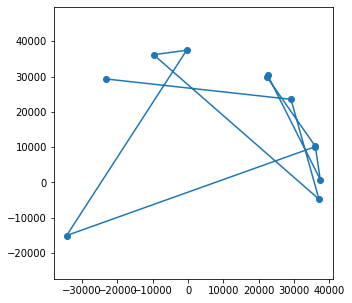

In [134]:
plt.figure(figsize=(5,5))
plt.plot(np.real(iq_mean), np.imag(iq_mean), "o-")
plt.axis("equal")
plt.show()

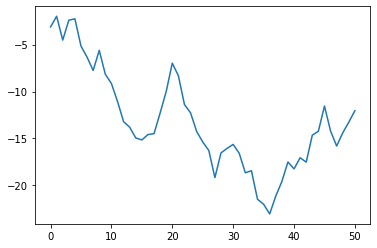

In [129]:
plt.plot(np.unwrap(np.angle(iq_mean)))

In [58]:
sr.CaptureCtrl.SAMPLING_RATE

500000000

## send_recv/send_recv.py

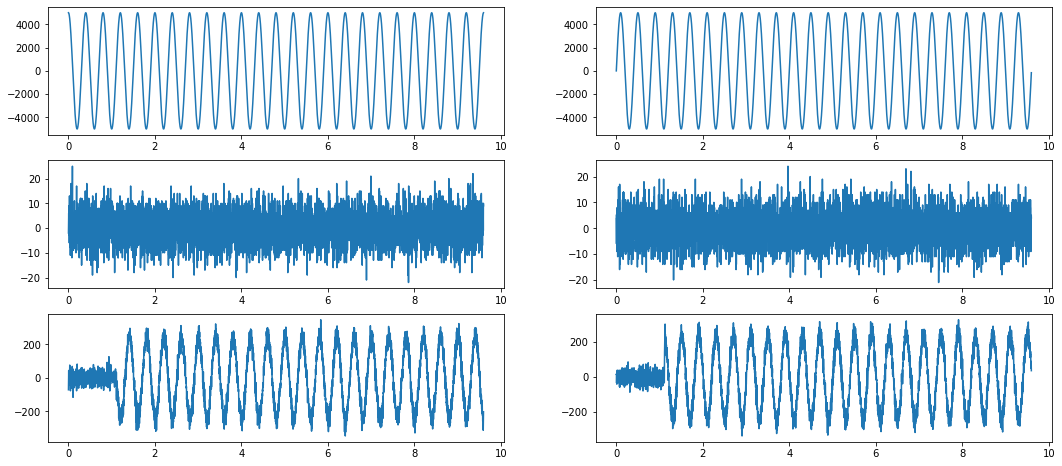

In [234]:
import e7awg_sw.examples.send_recv.send_recv as sr
from e7awg_sw.examples.send_recv.send_recv import AWG, CaptureModule

#sr.IP_ADDR = '10.1.0.23' #QUBE.config['ipfpga']
sr.IP_ADDR = QUBE.config['ipfpga']

def sendrecv(awgs, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*awgs)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, awgs[0], capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, awgs)
        # キャプチャパラメータの設定
        sr.set_capture_params(cap_ctrl, awg_to_wave_sequence[awgs[0]], capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*awgs)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *awgs)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, awgs, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        # 波形保存
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
    return awg_to_wave_data, capture_unit_to_capture_data
        # save_sample_data('awg', sr.AwgCtrl.SAMPLING_RATE, awg_to_wave_data)
        # save_sample_data('capture', sr.CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data)
    # print('end')

awgs = AWG.all()
o = sendrecv(awgs, CaptureModule.all(), False, 'localhost')

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

samples = o[1][0]
sampling_rate = sr.CaptureCtrl.SAMPLING_RATE
#sampling_rate = sr.AwgCtrl.SAMPLING_RATE
time = np.linspace(0, 1000000 * len(samples) / sampling_rate, len(samples), endpoint=False)

#print(len(samples), sampling_rate * 1e-6, time[0], time[-1])

tx_iq = np.array(o[0][0])
iq = np.array([v for k, v in o[1].items()])

f, axs = plt.subplots(3,2, figsize=(18,8))
axs[0,0].plot(time, tx_iq[:,0])
axs[0,1].plot(time, tx_iq[:,1])
axs[1,0].plot(time, iq[0,:,0])
axs[1,1].plot(time, iq[0,:,1])
axs[2,0].plot(time, iq[4,:,0])
axs[2,1].plot(time, iq[4,:,1])

# Rabi Vibration

In [ ]:
# 

## 参考資料

In [127]:
import qubelsi.qube
import inspect
import e7awgsw.awgctrl
print(inspect.getsource(qubelsi.adrf6780))
#print(inspect.getsource(qubelsi.lmx2594))
#print(inspect.getsource(qubelsi.ad9082))
#print(inspect.getsource(e7awgsw.awgctrl.AwgCtrl))

import qubelsi.udpsendrecv

class ADRF6780:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_mode(self):
        return self.handle.read_adrf6780(self.chip, 0x5)

    def set_usb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0000)

    def set_lsb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0400)

    def write_value(self, addr, value):
        return self.handle.write_adrf6780(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_adrf6780(self.chip, addr)

    def do_init(self, message_out=False, usb_mode=False):
        self.write_value(0x0, 0x4000)
        self.write_value(0x0, 0x0000)
        self.write_value(0x3, 0x0167)
        if usb_mode:
            self.write_value(0x5, 0x0000)
        else:            
            self.write_value(0x5, 0x0400)



In [31]:
print(inspect.getsource(qubelsi.lmx2594))

import qubelsi.udpsendrecv

class LMX2594:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_freq_100M(self):
        return self.handle.read_lmx2594(self.chip, 0x24)

    def write_freq_100M(self, value):
        val = self.handle.write_lmx2594(self.chip, 0x24, value)
        r0 = self.handle.read_lmx2594(self.chip, 0)
        self.handle.write_lmx2594(self.chip, 0, r0 | 0x08) # R0[3]=FCAL_EN
        return val

    def write_value(self, addr, value):
        return self.handle.write_lmx2594(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_lmx2594(self.chip, addr)

    def do_init(self, message_out=False, readout_mode=False, ad9082_mode=False):
        
        if ad9082_mode:
            self.write_value(0x00, 0x6612) # R6 [14]VCO_PHASE_SYNC=0
        else:
            self.write_value(0x00, 0x2612) # R6 [14]VCO_PHASE_SYNC=0, [9]OUT_MUTE=1
        

In [238]:
import qubecalib as qc
import pickle

PORT_ID = 0
VATT = 0xC00
TYPE = 'A'

qube = QUBE.qube

port = qc.new_port_handler(qube)

def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

set_sideband_config(qube.adrf6780, qube_type='A')


#fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
#result = []

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.losc, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.losc)

def set_nco(port, mhz):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)

# 9800, 10400, 11000
FL, FI = 8200, 1500
VATT = 0x800
PORT_ID=0
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
[set_nco_ifadc(port[PORT_ID], FI - 2.5, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)

FL = 11200
FI = 1500
VATT = 0xC00
PORT_ID=5
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)


2.4756043956043956